In [1]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from math import sqrt
from pandas import DataFrame, melt
#가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

#분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

#사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_gameshowell, pairwise_tests



In [2]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('sunlight_watering_growth')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/sunlight_watering_growth.xlsx
[desc] 식물의 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달 동안 자라게 한 후 각 식물의 높이를 인치 단위로 기록한 데이터 (출처: 방송통신대학교 통계학개론)

field    description
-------  ----------------------------------------------------------------
water    각 식물에 물을 주는 빈도 (매일:`daily`, 매주: `weekly`)
sun      각 식물이 받은 햇빛 노출량 (낮음:`low`, 중간:`med`, 높음:`high`)
height   2개월 후 각 식물의 높이 (인치)


===== 데이터 크기 확인 =====
데이터셋 크기 : (120, 3)
열 개수: 3
행 개수: 120

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   water   120 non-null    object 
 1   sun     120 non-null    object 
 2   height  120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB
None


,water,sun,height
0,daily,low,4.9
1,daily,low,7.9
2,daily,low,3.9
3,daily,low,5.1
4,daily,low,5.2


관수빈도별 햇빛 노출 빈도에 따른 식물 높이 비교

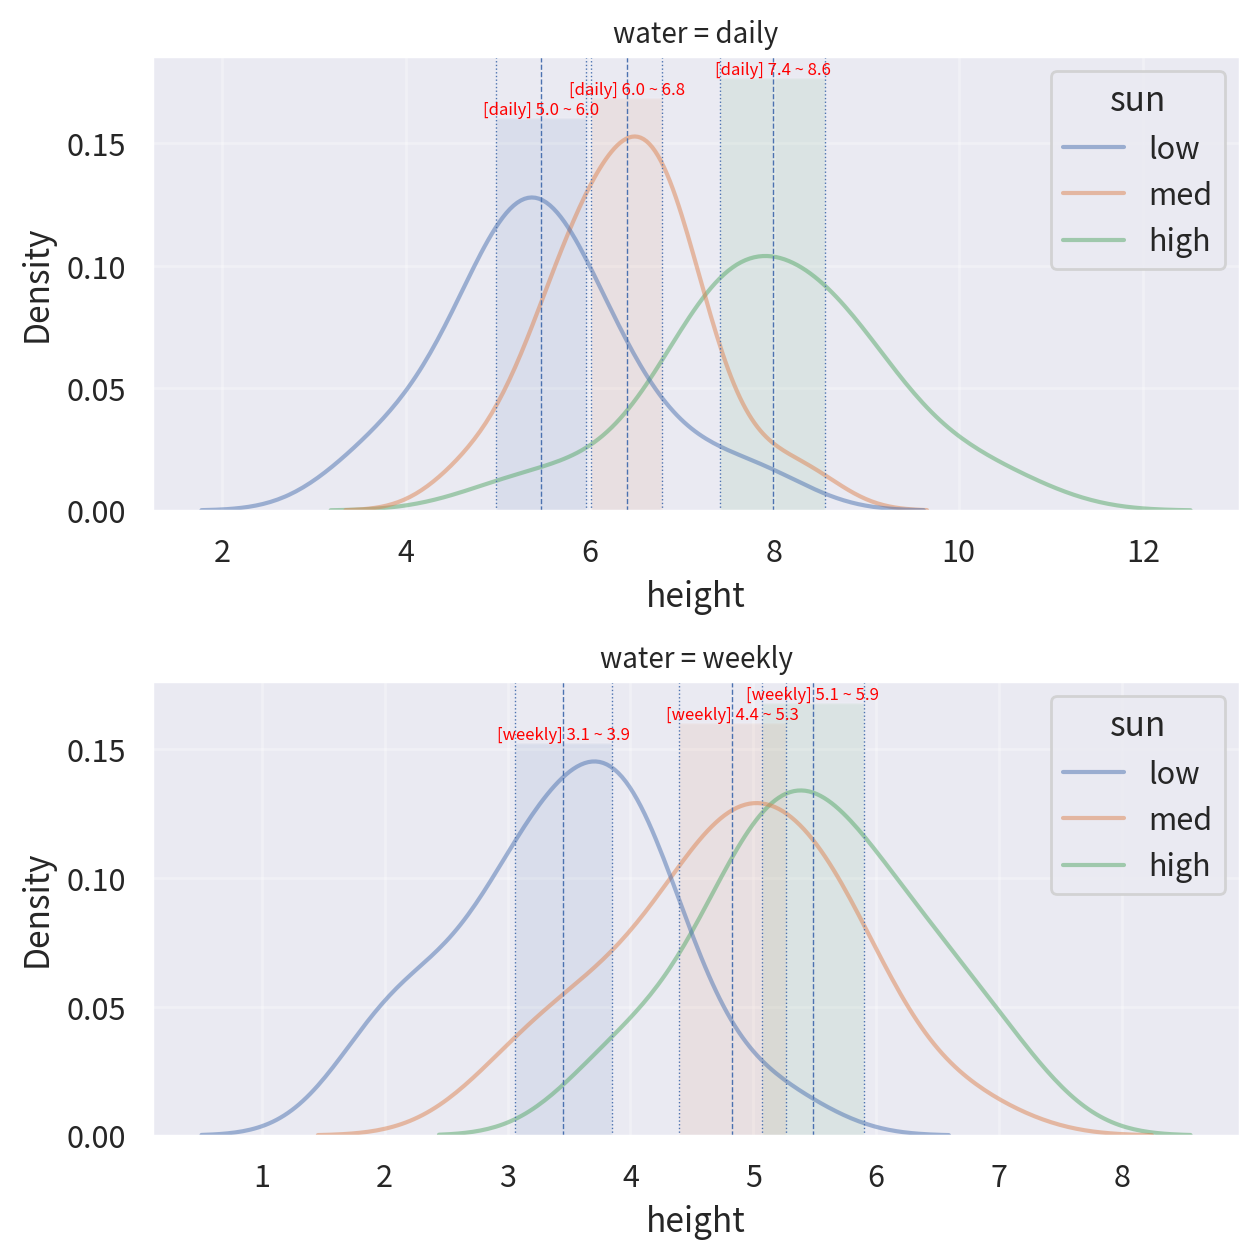

In [4]:
field = 'height'

group_field = 'water'
hue_field = 'sun'

data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
rows = group_count               #도화지의 행 수
cols = 1                    #도화지의 열 수
width_px = 1280 * cols            #그래프 가로 크기
height_px = 640 * rows             #그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(group_values):
    temp = data[data[group_field]==v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field]==h]

        # 신뢰구간
        max = temp_sub[field].max()                         #최대값
        clevel = 0.95                               #신뢰수준
        dof = len(temp_sub[field]) - 1                       #자유도
        sp_mean = temp_sub[field].mean()                    #표본평균
        sp_std = temp_sub[field].std(ddof = 1)           #표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field])) #표본표준오차
        cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        #평균 표시
        ymin,ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

        #텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

햇빛 노출 빈도별 관수량에 따른 식물 높이 비교

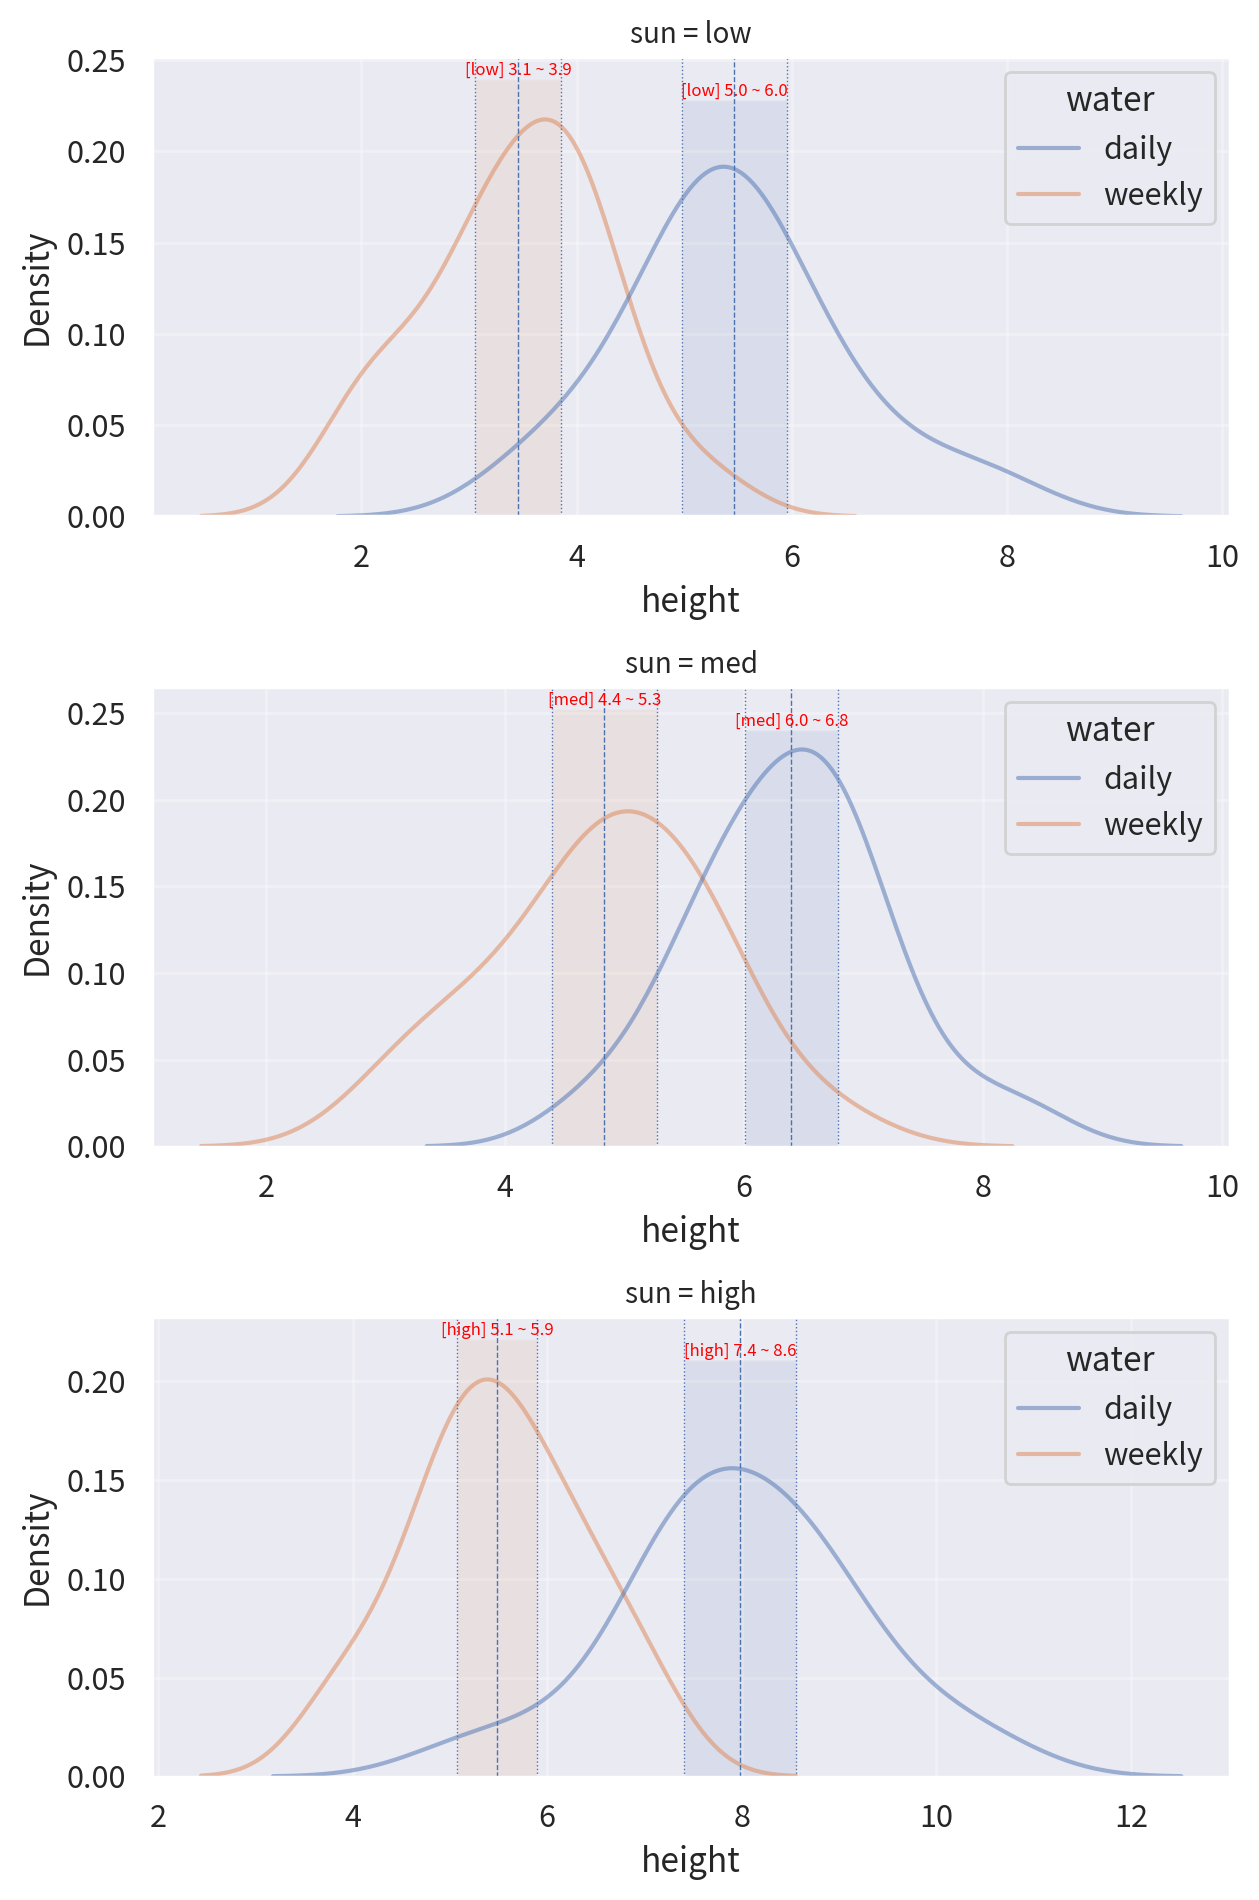

In [5]:
field = 'height'
group_field = 'sun'
hue_field = 'water'

data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
rows = group_count               #도화지의 행 수
cols = 1                    #도화지의 열 수
width_px = 1280 * cols            #그래프 가로 크기
height_px = 640 * rows             #그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(group_values):
    temp = data[data[group_field]==v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field]==h]

        # 신뢰구간
        max = temp_sub[field].max()                         #최대값
        clevel = 0.95                               #신뢰수준
        dof = len(temp_sub[field]) - 1                       #자유도
        sp_mean = temp_sub[field].mean()                    #표본평균
        sp_std = temp_sub[field].std(ddof = 1)           #표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field])) #표본표준오차
        cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        #평균 표시
        ymin,ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

        #텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

분산분석의 가정 확인

In [13]:
data = origin.copy()
xname = ['water','sun']
yname = 'height'

u1 = data[xname[0]].unique()    #첫 번째 독립변수의 범주들
u2 = data[xname[1]].unique()    #두 번째 독립변수의 범주들
# print(u1,u2)
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]]==i) & (data[xname[1]] == j)][yname]    #각 그룹별 데이터 추출
        equal_var_fields.append(filtered_data)
        s,p = normaltest(filtered_data)    #정규성 검정

        normalize = p>0.05
        report.append({
            "field": "{0}, {1}".format(i,j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s,p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s,p = levene(*equal_var_fields)

eqaul_var = p > 0.05

report.append({
    "field": "n",
    "statistic": s,
    "p-value": p,
    "result": eqaul_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
"daily, low",1.461514,0.481544,True
"daily, med",0.866582,0.648372,True
"daily, high",0.801917,0.669678,True
"weekly, low",0.073958,0.963697,True
"weekly, med",0.160764,0.922764,True
"weekly, high",0.052520,0.974082,True
n,4.488400,0.481437,True


이원분산분석

In [10]:
xname = ['water','sun']
yname='height'

pg_anova = anova(data=origin, dv=yname, between = xname)    #dv는 종속변수, between은 독립변수
pg_anova

,Source,SS,DF,MS,F,p-unc,np2
0,water,122.816333,1,122.816333,130.528994,1.301312e-20,0.533798
1,sun,103.292167,2,51.646083,54.889371,2.013276e-17,0.490568
2,water * sun,4.327167,2,2.163583,2.299453,1.049489e-01,0.038777
3,Residual,107.264000,114,0.940912,NaN,NaN,NaN


결과 문장 생성

In [11]:
for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f"-> {source}효과는 유의함. (대립가설 채택: p<=0.05)")
    else:
        print(f"-> {source}효과는 유의하지 않음. (귀무가설 채택: p>0.05)")

-> water효과는 유의함. (대립가설 채택: p<=0.05)
-> sun효과는 유의함. (대립가설 채택: p<=0.05)
-> water * sun효과는 유의하지 않음. (귀무가설 채택: p>0.05)
-> Residual효과는 유의하지 않음. (귀무가설 채택: p>0.05)


ANOVA는 데이터를 설명되는 부분 + 설명되지 않는 부분으로 나눈다.
> 총 제곱합(SS Total) = 요인 A(water)로 설명되는 부분 + 요인 B(sun)으로 설명되는 부분 + 상호작용(water x sun)으로 설명되는 부분 + 남은 부분(Residual)

Residual = 모델이 설명할 수 없는 개별 오차
- 동일 조건인데도 식물 키(height)가 조금씩 다른 자연 변동
- 측정 오차
- 눈에 보이지 않는 다른 요인들(토양의 미세 차이, 개체 특성 등)
- 모델에서는 고려하지 않은 모든 외부 영향
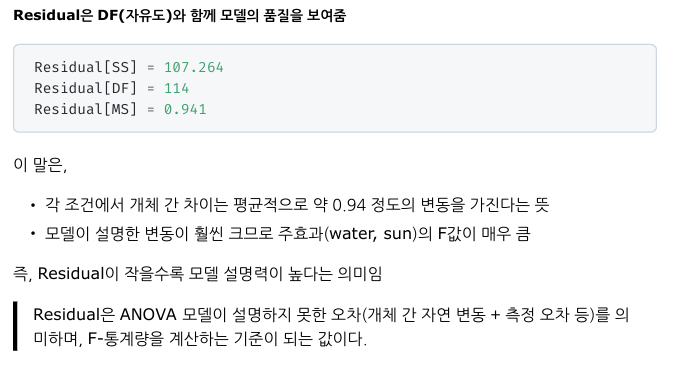

사후검정

In [15]:
xname = ['water','sun']
yname = 'height'
data = origin[xname + [yname]]

levels = {}

for factor in xname:
    level_count = data[factor].nunique()
    levels[factor] = level_count

pvals = {}

for index, row in pg_anova.iterrows():
    source_name = row['Source']
    p_value = row['p-unc']
    pvals[source_name] = p_value

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor] <=2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) -> 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) -> 사후검정 수행")
    equal_var = p >0.05
    if equal_var:
        print("  - Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
        display(hoc_df)
    else:
        print("  - Games-Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)
        display(hoc_df)

interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) -> 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) -> 단순주효과 분석 필요 없음")


[water]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[sun]
- 주효과 유의 (p=2.01e-17) -> 사후검정 수행
  - Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,high,low,6.7325,4.4600,2.2725,0.316503,7.180027,2.079377e-10,1.480100
1,high,med,6.7325,5.6125,1.1200,0.316503,3.538671,1.663237e-03,0.775153
2,low,med,4.4600,5.6125,-1.1525,0.316503,-3.641356,1.172021e-03,-0.888359



[water * sun] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.105) -> 단순주효과 분석 필요 없음


### #03. 인사이트

#### 1. 분석목적

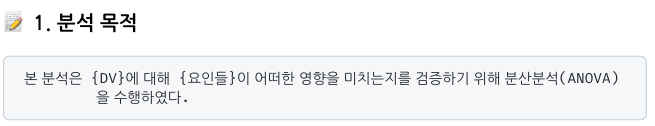

- 본 분석은 식물의 높이(height)에 대해 관수 빈도(water)와 햇빛 노출(sun)이 어떤 영향을 미치는지 평가하기 위해 이원분산분석(two-way ANOVA)을 수행하였다.

#### 2. 분산분석 주요 결과
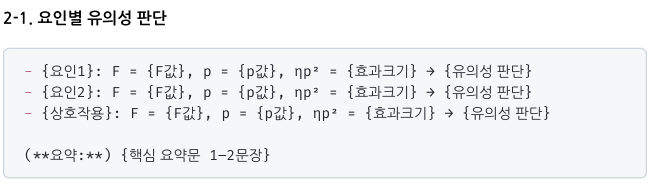

- water : F= 130.53, p= 1.30e-20, np^2 = 0.534 -> 유의함(대립가설 채택)
- sun : F=54.89, p= 2.01e-17, np^2 = 0.491 -> 유의함(대립가설 채택)
- water x sun : F=2.30, p= 0.105, np^2 = 0.039 -> 유의하지 않음(귀무가설 채택)

- 물주기와 햇빛은 식물 높이에 모두 유의한 영향을 주지만, 두 요인이 결합해 특별한 상호작용 효과를 만들어내지는 않는다.

#### 3. 기술통계 및 집단별 평균 비교
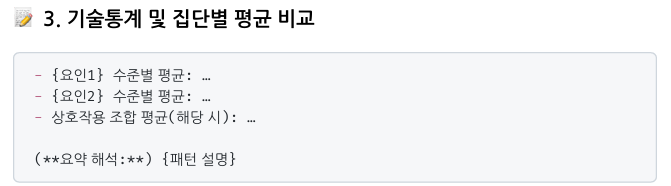

- water 수준별 평균
    - daily : 6.63
    - weekly : 4.57
        -> 매일 물 준 그룹이 크게 성장함.

- sun 수준별 평균
    - low : 4.44
    - med : 5.61
    - high : 6.73
        -> 햇빛이 많을수록 뚜렷한 증가.

#### 4. 사후검정(Post-hoc) 결과

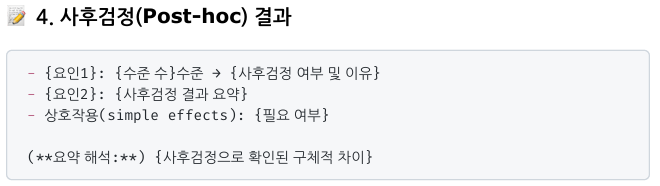

- water: 2수준 요인이므로 사후검정 불필요.
- sun: 3수준 + 주효과 유의 -> Tukey HSD 수행
    - high > low(차이 2.27, p<.001>)
    - high > med(차이 1.12, p<.01>)
    - med > low (차이 1.15, p<.01>)
- 상호작용: p=0.105 -> 단순주효과 분석 불필요

햇빛의 세 조건(low, med, high)은 서로 모두 유의하게 다른 평균을 가진다.

#### 5. 최종 결론 요약

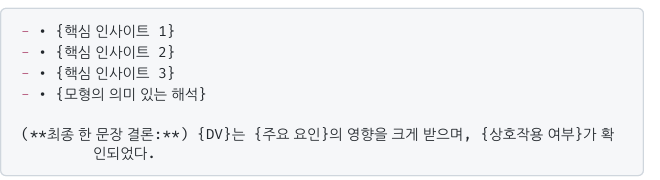
- - 관수(water)는 식물의 성장에 강력한 영향을 줌(매일 물을 줄수록 더 큼).
- - 햇빛(sun)은 명확한 선형적 효과를 가지며, high> med> low 순으로 성장 증가.
- - 두 요인이 결합해 상승효과를 만드는 상호작용은 없음.
- - 사후 검정 결과, 햇빛 조건 세 그룹은 모두 서로 유의하게 차이가 있음.

식물의 높이는 관수 빈도와 햇빛 수준의 영향을 크게 받으며, 두 요인은 독립적으로 작용하여 성장 패턴을 결정한다.